# Borchifycation of network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F

from borch.borch import borchify_network
from torch.nn import Module
from torchvision.datasets import MNIST
from torchvision import transforms

%matplotlib inline

## Load data and set global training variables

In [2]:
# todo: normalise using mean/std of full training dataset
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.], [1.0])])

trainset = MNIST(os.getenv("DATASET_MNIST"), train=True, transform=trans, download=True)
testset = MNIST(os.getenv("DATASET_MNIST"), train=False, transform=trans, download=True)

In [3]:
batch_size = 20
n_epochs = 10
n_input = 784
n_classes = 10
display_step = 1  # print status every `display_step` epochs

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=len(testset),
    shuffle=False,
    num_workers=4
)

# pre-load the test data
for x_test, y_test in test_loader:
    break

for image, label in train_loader:
    break

In [4]:
n_train_examples = len(trainset)
n_batches_per_epoch = int(n_train_examples / batch_size)
n_batches_total = n_batches_per_epoch * n_epochs

print("Number of training examples:", n_train_examples)
print("Number of testing examples: ", len(testset))

Number of training examples: 60000
Number of testing examples:  10000


## Define the network to be trained

We'll specify a fairly small CNN with batch normalisation after the first two convolutional layers.

In [5]:
class CNN(Module):
    """Four layer non-Bayesian neural network with two convolutional (and
    batch normalisation following each of these) and two fully connected
    layers."""
    def __init__(self, n_in, n_conv1, n_conv2, n_fc1, n_out):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(n_in, n_conv1, kernel_size=5, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(n_conv1)
        self.conv2 = torch.nn.Conv2d(n_conv1, n_conv2, kernel_size=5, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(n_conv2)
        self.n_at_fc1 = 4*4*n_conv2  # NB manually calculated
        self.fc1 = torch.nn.Linear(self.n_at_fc1, n_fc1)
        self.bn3 = torch.nn.BatchNorm1d(n_fc1)
        self.fc2 = torch.nn.Linear(n_fc1, n_out)

    def forward(self, x):
        h = self.bn1(F.relu(self.conv1(x)))
        h = self.bn2(F.relu(self.conv2(h)))
        h = self.bn3(F.relu(self.fc1(h.view(-1, self.n_at_fc1))))
        return F.softmax(self.fc2(h), dim=1)

## Create the networks

In [6]:
cnn = CNN(1, 10, 10, 100, 10)
bcnn = CNN(1, 10, 10, 100, 10)
borchify_network(bcnn)  # NB borchify is in-place

In [7]:
# note that we now have twice as many parameters (all weights/biases
# now have a corresponding logvar)

def total_params(net):
    return sum([sum(x.size()) for x in net.parameters()])

print(f"Total parameters in cnn:   {total_params(cnn)}")
print(f"Total parameters in bcnn: {total_params(bcnn)}")

Total parameters in cnn:   791
Total parameters in bcnn: 1582


## Train a Bayesian CNN

In [8]:
def one_hot(labels):
    onehot = torch.zeros(labels.size(0), n_classes)
    onehot.scatter_(1, labels.view(-1, 1), 1.0)
    return onehot

def loss_fn(coef, preds, y, kl):
    bce = F.binary_cross_entropy(preds, one_hot(y), size_average=False)
    return (coef * kl + bce) / y.size(0)

In [10]:
opt = torch.optim.Adam(bcnn.parameters(), lr=1e-4)
n_samples = 1
coef = 1 / 5000  # todo: tune this!

for epoch in range(n_epochs):
    rl = 0  # running loss
    bcnn.sampling(True)
    bcnn.train(True)

    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()
        
        # coef = pi(i, n_batches_total)
        loss = 0
        for _ in range(n_samples):
            preds = bcnn(x)
            loss += loss_fn(coef, preds, y, bcnn.divergence())
        loss = loss / n_samples
        loss.backward()

        opt.step()
        rl += loss.data / n_batches_per_epoch

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        bcnn.sampling(False)
        bcnn.train(False)
        bcnn_test_preds = bcnn(x_test)
        bcnn_test_correct = bcnn_test_preds.max(dim=1)[1] == y_test
        bcnn_test_acc = 100. * torch.mean(bcnn_test_correct.data.float())
        print(f"[Epoch {epoch+1:>3}]  |  Running loss: {float(rl):7.2f} ({bcnn_test_acc:4.2f}%)")

[Epoch   1]  |  Running loss:    2.56 (88.61%)
[Epoch   2]  |  Running loss:    1.23 (94.37%)
[Epoch   3]  |  Running loss:    0.95 (96.01%)
[Epoch   4]  |  Running loss:    0.87 (96.79%)
[Epoch   5]  |  Running loss:    0.80 (97.28%)
[Epoch   6]  |  Running loss:    0.77 (97.55%)
[Epoch   7]  |  Running loss:    0.74 (97.87%)
[Epoch   8]  |  Running loss:    0.73 (98.00%)
[Epoch   9]  |  Running loss:    0.71 (98.26%)
[Epoch  10]  |  Running loss:    0.69 (98.38%)


## Train a non-Bayesian CNN

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    rl = 0  # running loss
    cnn.train(True)
    
    for batch, (x, y) in enumerate(train_loader):
        opt.zero_grad()

        preds = cnn(x)
        loss = loss_fn(preds, y)
        loss.backward()
        opt.step()
        rl += loss.data / n_batches_per_epoch

    if (epoch % display_step) == 0 or epoch == n_epochs - 1:
        cnn.train(False)
        cnn_test_preds = cnn(x_test)
        cnn_test_correct = cnn_test_preds.max(dim=1)[1] == y_test
        cnn_test_acc = 100. * torch.mean(cnn_test_correct.data.float())
        print(f"[Epoch {epoch+1:>3}]  |  Running loss: {float(rl):7.2f} ({cnn_test_acc:4.2f}%)")

[Epoch   1]  |  Running loss:    1.72 (96.23%)
[Epoch   2]  |  Running loss:    1.52 (97.27%)
[Epoch   3]  |  Running loss:    1.50 (97.76%)
[Epoch   4]  |  Running loss:    1.49 (97.97%)
[Epoch   5]  |  Running loss:    1.49 (98.33%)
[Epoch   6]  |  Running loss:    1.49 (98.23%)
[Epoch   7]  |  Running loss:    1.48 (98.43%)
[Epoch   8]  |  Running loss:    1.48 (98.59%)
[Epoch   9]  |  Running loss:    1.48 (98.49%)
[Epoch  10]  |  Running loss:    1.48 (98.66%)


## Compare the Two!

To demonstrate, we'll compare the likelihood of the misclassified predictions (NB using the means of the parameters in the Bayesian CNN).
We expect to see that for misclassified images the Bayesian network gives much more uncertain predictions (respresenting a much more sane result).

In [27]:
# calculate number of incorrect predictions
cnn_indices_predicted_wrong = np.where(cnn_test_correct.data.cpu().numpy() == 0)[0]
bcnn_indices_predicted_wrong = np.where(bcnn_test_correct.data.cpu().numpy() == 0)[0]

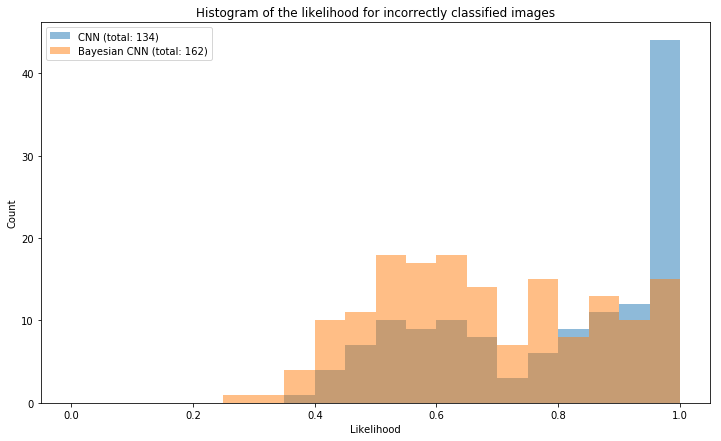

In [28]:
bins = np.linspace(0, 1.0, 21)
plt.figure(figsize=(12, 7))

plt.hist(
    cnn_test_preds.max(dim=1)[0].data.cpu().numpy()[cnn_indices_predicted_wrong],
    label=f"CNN (total: {len(cnn_indices_predicted_wrong)})", bins=bins, alpha=0.5
)

plt.hist(
    bcnn_test_preds.max(dim=1)[0].data.cpu().numpy()[bcnn_indices_predicted_wrong],
    label=f"Bayesian CNN (total: {len(bcnn_indices_predicted_wrong)})", bins=bins, alpha=0.5
)

plt.title("Histogram of the likelihood for incorrectly classified images")
plt.xlabel("Likelihood")
plt.ylabel("Count")
plt.legend()
plt.show()

In [87]:
both_incorrect = np.intersect1d(bcnn_indices_predicted_wrong, cnn_indices_predicted_wrong)
i = both_incorrect[1]  # I chose index 1 here but take any 
image, label = testset[i]

In [106]:
def draw_prediction_samples(net, n_draws=1000):
    return torch.stack([net(image.view(1, 1, 28, 28)) for _ in range(n_draws)]).squeeze().detach().numpy()

bcnn.train(False)
bcnn.sampling(True)
bcnn_preds = draw_prediction_samples(bcnn)
bcnn_correct_likl = bcnn_preds[:, label]

cnn.train(False)
cnn_preds = draw_prediction_samples(cnn)
cnn_correct_likl = cnn_preds[:, label]

bcnn_mean_pred = bcnn_preds.mean(axis=0).argmax()
cnn_mean_pred = cnn_preds.mean(axis=0).argmax()

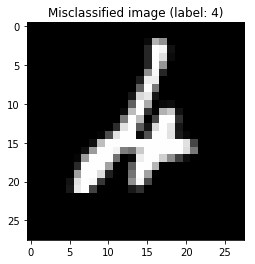

In [92]:
plt.imshow(image.detach().numpy().squeeze(), cmap='gray')
plt.title(f"Misclassified image (label: {label})")
plt.show()

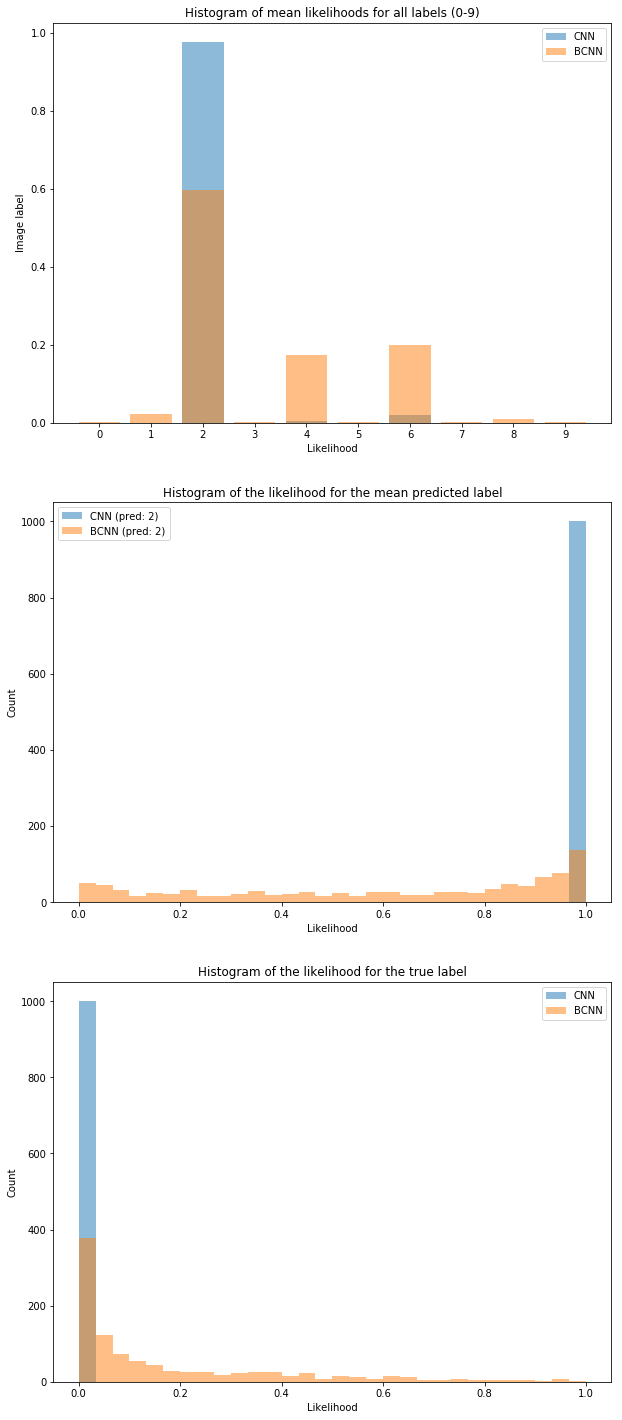

In [127]:
bins = np.linspace(0, 1, 31)

gif, ax = plt.subplots(3, 1, figsize=(10, 25))

ax[0].bar(range(10), cnn_preds.mean(0), alpha=0.5, label="CNN")
ax[0].bar(range(10), bcnn_preds.mean(0), alpha=0.5, label="BCNN")
ax[0].set_title("Histogram of mean likelihoods for all labels (0-9)")
ax[0].set_xlabel("Likelihood")
ax[0].set_ylabel("Image label")
ax[0].set_xticks(range(10))
ax[0].legend()

ax[1].hist(cnn_preds[:, cnn_mean_pred], label=f"CNN (pred: {cnn_mean_pred})", bins=bins, alpha=0.5)
ax[1].hist(bcnn_preds[:, bcnn_mean_pred], label=f"BCNN (pred: {bcnn_mean_pred})", bins=bins, alpha=0.5)
ax[1].set_title("Histogram of the likelihood for the mean predicted label")
ax[1].set_xlabel("Likelihood")
ax[1].set_ylabel("Count")
ax[1].legend()

ax[2].hist(cnn_correct_likl, label="CNN", bins=bins, alpha=0.5)
ax[2].hist(bcnn_correct_likl, label="BCNN", bins=bins, alpha=0.5)
ax[2].set_title("Histogram of the likelihood for the true label")
ax[2].set_xlabel("Likelihood")
ax[2].set_ylabel("Count")
ax[2].legend()

plt.show()